# Este notebook realiza as seguintes tarefas:
   * O tratamento do texto bruto: Full_text
   * Estatística e análise do dataset
   * Classificação dos emails: spam, não spam

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import time

# stopwords
* [list of stopwords](https://countwordsfree.com/stopwords/english/)

In [2]:
df = pd.read_csv("sms_senior.csv", encoding="ISO-8859-1")

In [3]:
df.drop_duplicates(inplace=True)
df.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


##  Trantando o texto bruto

In [4]:
def treatText(emails):
    treated_text = []
    for text in emails:
        
        text = text.lower()     
        # punctuation
        regex_punctuation = r"(?!\d)[.,#&)(!;*:><-?](?!\d)"
        text = re.sub(regex_punctuation, "", text, 0)

        #removing numbers
        text = re.sub(r'[0-9]+', "", text)
        
        characters = ["\n", '"', "*", "/", "-", "(", ":", "!"]
        for c in characters:
            text = text.replace(c, " ")

        text = re.sub('\s+',' ',text) # double spaces
        
        text_to_list = text.split()
        with open("./stopwords.txt") as file:
            stop_words = [w.rstrip() for w in file]
            
        #resoving stopwords
        result = [word for word in text_to_list if word not in stop_words]

        word_set = [word for word in result if len(set(word.lower())) > 2]
        
        result_text = ' '.join(word_set)
        treated_text.append(result_text)
        
        #remove empty strings
        treated_text = list(filter(None, treated_text))
    return treated_text

In [5]:
treated_text = treatText(df.Full_Text)
treated_text[:5]

['congrats',
 'flat alot wiv work woman coming',
 'urgent landline complimentary tenerife holiday cash await collection sae tcs box',
 'hide anythiing keeping distance',
 'mobile work online send wil explain']

# Palavras mais frequêntes - WordCloud

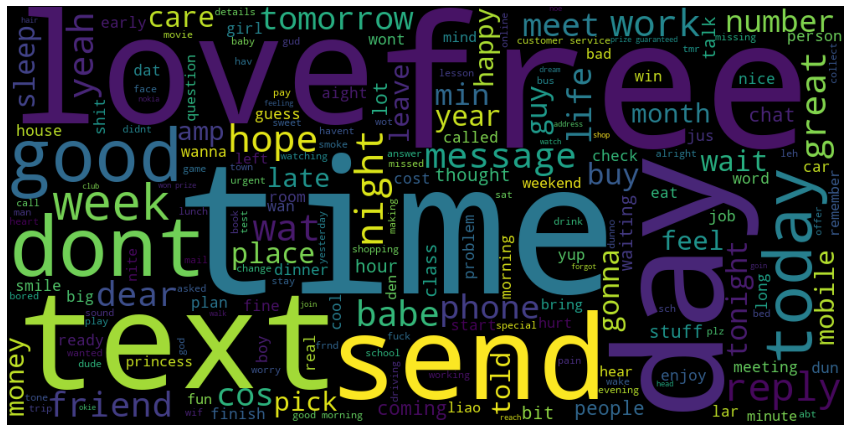

In [6]:
#list to string
unique_string=(" ").join(treated_text)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud.png", bbox_inches='tight') # save figure
plt.show()
plt.close()

* Todas as colunas com exceção de Full_Text

In [7]:
df_analise = df.iloc[:,1:]

In [8]:
df_analise.head(1)

,got,great,wat,free,text,txt,win,already,dun,say,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no


* Date para Datetime
    * Perído correspondente ao dataset - Data mínima e máxima

In [9]:
df_analise['Date'] = pd.to_datetime(df_analise['Date'], format='%Y-%m-%d')
print("Período:",df_analise.Date.min(), " - ",df_analise.Date.max())

Período: 2017-01-01 00:08:00  -  2017-03-31 23:56:00


In [10]:
df_analise.set_index("Date", inplace=True)

In [11]:
df_analise.tail(2)

,got,great,wat,free,text,txt,win,already,dun,say,...,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,IsSpam
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-31 23:32:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3,11,no
2017-03-31 23:56:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,no


In [12]:
df_analise_month = df_analise.loc[:, "got":"wan"].groupby(pd.Grouper(freq="M")).sum().round(2)
max_wors = df_analise_month.max().nlargest(n=10).index
print("Qunatidade de colunas: ",len(df_analise_month.columns))

Qunatidade de colunas:  149


* As 10 palavras mais frequênte por mês

In [13]:
max_wors = max_wors.to_list()
max_wors

['call', 'now', 'can', 'will', 'get', 'just', 'free', 'ltgt', 'dont', 'like']

* dataset normalizado entre 0 e 1

In [14]:
df_normalized = df_analise_month[max_wors]
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0).fillna(0)
df_normalized

,call,now,can,will,get,just,free,ltgt,dont,like
Date,,,,,,,,,,
2017-01-31,0.166023,0.133591,0.106564,0.108880,0.105019,0.099614,0.091892,0.053282,0.074131,0.061004
2017-02-28,0.156415,0.121265,0.100176,0.101054,0.099297,0.100176,0.063269,0.079086,0.092267,0.086995
2017-03-31,0.148852,0.133017,0.121140,0.100554,0.111639,0.098971,0.068884,0.092637,0.072051,0.052257


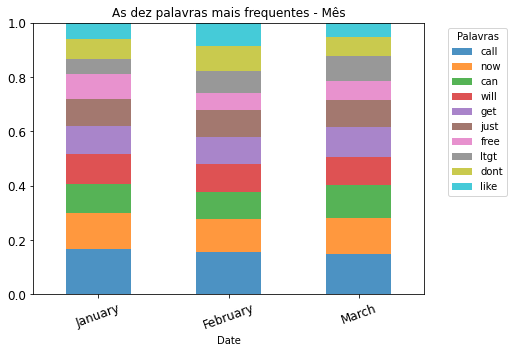

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
df_normalized.plot(kind="bar", stacked=True, alpha=0.8,fontsize=12, rot =20, ax=ax)
plt.legend(title='Palavras', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(np.arange(len(df_normalized.index.month_name())), df_normalized.index.month_name())
plt.title("As dez palavras mais frequentes - Mês")
plt.ylim([0,1])
plt.show()

#### máximo,  mínimo, média,  mediana,  desvio padrão e  variância - (Word_Count) / mês

In [16]:
df_analise_estatisticas = df_analise.loc[:, ["Word_Count"]].groupby(pd.Grouper(freq="M"))["Word_Count"].agg(["max", "min","mean","median","std","var"])
df_analise_estatisticas

,max,min,mean,median,std,var
Date,,,,,,
2017-01-31,190,2,16.336918,13,12.557171,157.682535
2017-02-28,100,2,16.029043,13,11.042459,121.935908
2017-03-31,115,2,16.285255,12,11.576213,134.008715


### Mensagens comuns e spams

In [17]:
df_analise_spam = df_analise[["IsSpam"]].loc[df_analise["IsSpam"] == "yes"].groupby(pd.Grouper(freq="M"))["IsSpam"].agg(["count"]).rename(columns={"count": "spam"})
df_analise_notspam = df_analise[["IsSpam"]].loc[df_analise["IsSpam"] == "no"].groupby(pd.Grouper(freq="M"))["IsSpam"].agg(["count"]).rename(columns={"count": "comum"})
df_analise_spam_mes = pd.concat([df_analise_spam, df_analise_notspam], axis=1, sort=False)
df_analise_spam_mes

,spam,comum
Date,,
2017-01-31,266,1687
2017-02-28,244,1512
2017-03-31,237,1628


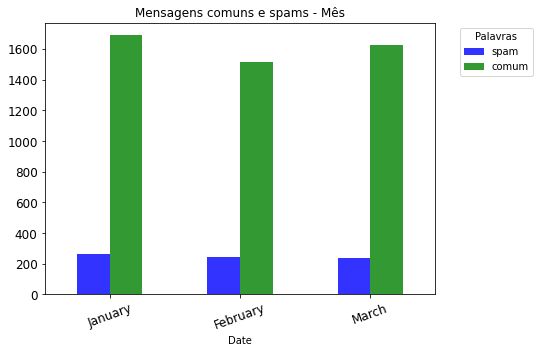

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
df_analise_spam_mes.plot(kind="bar", alpha=0.8,fontsize=12, rot =20, color=["blue", "green"], ax=ax)
plt.legend(title='Palavras', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(np.arange(len(df_normalized.index.month_name())), df_normalized.index.month_name())
plt.title("Mensagens comuns e spams - Mês")
plt.show()

## Máximos msg comuns / Mês-Dia

In [19]:
df_notspam = df_analise.loc[df_analise["IsSpam"] == "no"].copy()
df_notspam['month'] = df_notspam.index.strftime('%b')
df_notspam['day'] = df_notspam.index.strftime('%d')
df_notspam = df_notspam.groupby(["month", "day"])["IsSpam"].agg(["count"]).rename(columns={"count": "comum"}).reset_index()
df_notspam = df_notspam.loc[df_notspam.groupby('month')['comum'].idxmax()]
df_notspam

,month,day,comum
12,Feb,13,72
28,Jan,01,69
66,Mar,08,69


# Classificação - ( MultinomialNB vs RandomForestClassifier)


* classes- categoricas para númerico

In [20]:
df_analise["IsSpam_le"] =  df_analise.IsSpam.map({ 'no': 0,'yes': 1})

In [21]:
df_analise.head(2)

,got,great,wat,free,text,txt,win,already,dun,say,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,IsSpam,IsSpam_le
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:08:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,no,0
2017-01-01 00:19:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,no,0


# Checando Balanceamento das classes

In [22]:
def plot_classes(df, col):
    from pandas.plotting import table
    plt.figure(figsize=(15,8))

    ax0 = plt.subplot(121, aspect='equal')

    df[col].value_counts().plot(kind='pie', ax=ax0, autopct='%1.1f%%',
                                     explode=(0,0.05), shadow=True, colors=["pink", "lightblue"],
                                         startangle=90, legend = False, fontsize=12)
    ax1 = plt.subplot(122)
    plt.axis('off')
    tbl = table(ax1, df[col].value_counts(), loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(14)
    plt.show()

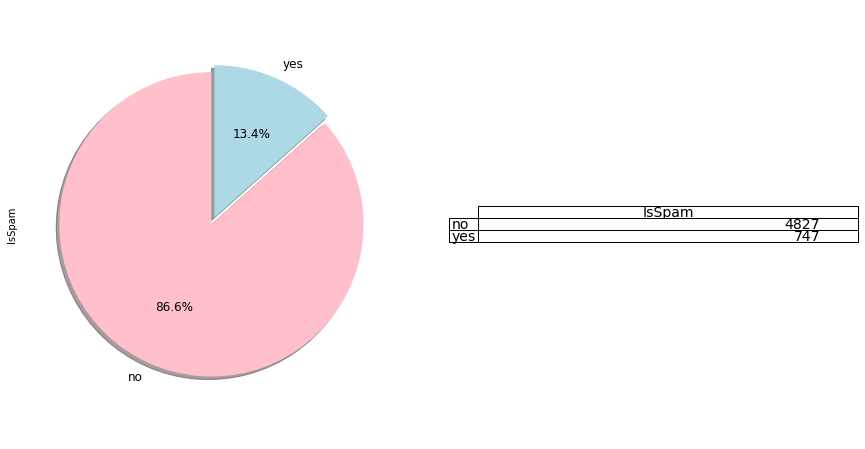

In [23]:
plot_classes(df_analise, "IsSpam")

 * O problema do treino com classes desbalanceadas é o fato de o modelo aprender muito bem uma classe e nem tanto a outra, podendo retornar uma acurácia desbalanceada.

#### Dataset Original

In [24]:
# características e classes
y = df_analise["IsSpam_le"]
X = df_analise.drop(["IsSpam", "IsSpam_le"], axis=1)

In [25]:
X.tail(2)

,got,great,wat,free,text,txt,win,already,dun,say,...,mins,phone,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-31 23:32:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,11
2017-03-31 23:56:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


* Conjunto de treino e teste

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

In [27]:
def train(model, X_train, y_train):
    return model.fit(X_train, y_train)

def evaluate(modelA, modelB, X_test, y_test):
    print("model A", "\n")
    y_predicted_a = modelA.predict(X_test)
    print('Precisão : ', accuracy_score(y_test,y_predicted_a), "\n")
    print(classification_report(y_test ,y_predicted_a))
    
    print("model B","\n")
    y_predicted_b = modelB.predict(X_test)
    print('Precisão: ', accuracy_score(y_test,y_predicted_b), "\n")
    print(classification_report(y_test ,y_predicted_b))

### modelA - MultinomialNB 

In [28]:
start_time = time.time()
model_bayes = train(MultinomialNB(), X_train, y_train)
model_bayes
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.015468120574951172 seconds ---


### modelB  - RandomForestClassifier

In [29]:
start_time = time.time()
model_rforest = train(RandomForestClassifier(), X_train, y_train)
model_rforest
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5516903400421143 seconds ---


### Avaliando os modelos para o dataset original

In [30]:
evaluate(model_bayes,model_rforest, X_test, y_test)

model A 

Precisão :  0.9521817095038853 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1449
           1       0.87      0.75      0.81       224

    accuracy                           0.95      1673
   macro avg       0.92      0.87      0.89      1673
weighted avg       0.95      0.95      0.95      1673

model B 

Precisão:  0.9617453676031081 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1449
           1       0.92      0.79      0.85       224

    accuracy                           0.96      1673
   macro avg       0.94      0.89      0.91      1673
weighted avg       0.96      0.96      0.96      1673



### Lindando com desbalanceamento de classes
   * Upsample vs Downsample
       * Up-sampling é o processo de duplicar aleatoriamente as observações da classe minoritária para aumentar seu número de amostras
       * Downsampling é a redução da amostragem de forma aleatória de observações da classe majoritária aproxímando seu número de amostras ao número de amostras da classe minoritária.

### Upsample

In [31]:
# Separando as classes
maioria = df_analise.loc[df_analise.IsSpam_le==0]
minoria = df_analise.loc[df_analise.IsSpam_le==1]
 
# Upsample
minoria_upsampled = resample(minoria,replace=True, n_samples=len(maioria), random_state=123)
 
df_upsampled = pd.concat([maioria, minoria_upsampled])

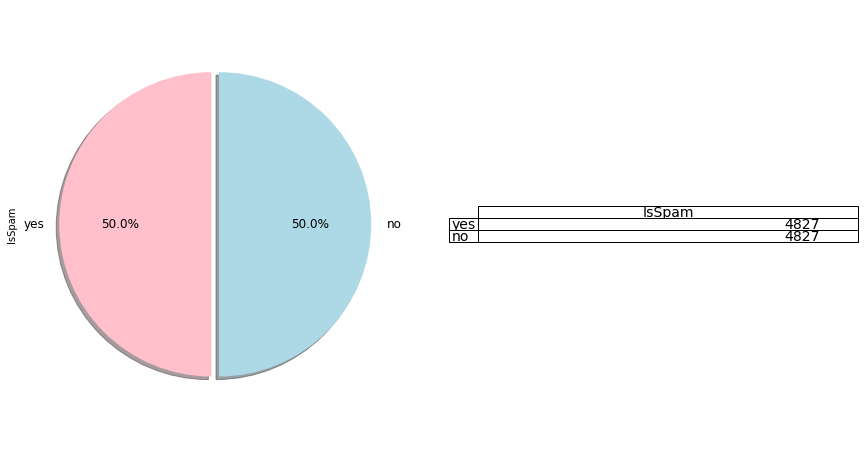

In [32]:
plot_classes(df_upsampled, "IsSpam")

### Downsample

In [33]:
# Separando as classes
maioria = df_analise.loc[df_analise.IsSpam_le==0]
minoria = df_analise.loc[df_analise.IsSpam_le==1]
 
# Dowbsample
maioria_downsampled = resample(maioria,replace=True, n_samples=len(minoria), random_state=123)
 
df_downsampled = pd.concat([minoria, maioria_downsampled])

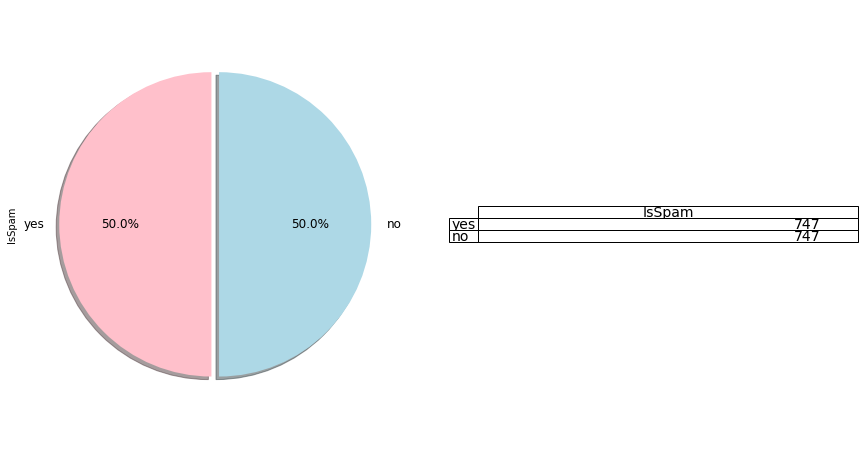

In [34]:
plot_classes(df_downsampled, "IsSpam")

* __Dataset Upsampled__

In [35]:
# características e classes
y = df_upsampled["IsSpam_le"]
X = df_upsampled.drop(["IsSpam", "IsSpam_le"], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

In [37]:
start_time = time.time()
model_bayes = train(MultinomialNB(), X_train, y_train)
model_bayes
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.020453691482543945 seconds ---


In [38]:
start_time = time.time()
model_rforest = train(RandomForestClassifier(), X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))
model_rforest

--- 0.825838565826416 seconds ---


RandomForestClassifier()

### Avaliando os modelos para o dataset Upsampled

In [39]:
evaluate(model_bayes,model_rforest, X_test, y_test)

model A 

Precisão :  0.9206075250258888 

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1449
           1       0.93      0.91      0.92      1448

    accuracy                           0.92      2897
   macro avg       0.92      0.92      0.92      2897
weighted avg       0.92      0.92      0.92      2897

model B 

Precisão:  0.979288919571971 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1449
           1       0.97      0.99      0.98      1448

    accuracy                           0.98      2897
   macro avg       0.98      0.98      0.98      2897
weighted avg       0.98      0.98      0.98      2897



* __Dataset Downsampled__

In [40]:
# características e classes
y = df_downsampled["IsSpam_le"]
X = df_downsampled.drop(["IsSpam", "IsSpam_le"], axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

In [42]:
model_bayes = train(MultinomialNB(), X_train, y_train)
model_bayes
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.740851879119873 seconds ---


In [43]:
model_rforest = train(RandomForestClassifier(), X_train, y_train)
model_rforest
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.1468183994293213 seconds ---


### Avaliando os modelos para o dataset Downsampled

In [44]:
evaluate(model_bayes,model_rforest, X_test, y_test)

model A 

Precisão :  0.89086859688196 

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       225
           1       0.93      0.85      0.89       224

    accuracy                           0.89       449
   macro avg       0.89      0.89      0.89       449
weighted avg       0.89      0.89      0.89       449

model B 

Precisão:  0.9198218262806236 

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       225
           1       0.93      0.91      0.92       224

    accuracy                           0.92       449
   macro avg       0.92      0.92      0.92       449
weighted avg       0.92      0.92      0.92       449



# Considerações
   * Podemos observar que o dataset original está extremamente desbalanceado, mesmo assim a classificação foi relativamente boa (acertando acima de 80% ambas as classes e ambos os modelos), entretanto é notório que uma classe está sendo acertada mais que a outra. Esse é um dos efeitos do desbalanceamento de classes.
   
* Métodos para lidar com o desbalanceamento foram aplicadas: Upsampled e Downsampled
    * De acordo com os resultados, pode-se observar que existe um equilibrio de acertos para ambas as classe, Tando para o Upsampled quanto para Downsampled, sendo o Upsampled com o algoritmo RandomForestClassifier os responsáveis pelo melhor resultado com 0.97 de precisão.